In [21]:
import numpy as np
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.utils import class_weight
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Embedding,LSTM,Bidirectional
from tensorflow.keras.callbacks import EarlyStopping


In [22]:
df=pd.read_csv(r'C:\Users\User\Downloads\archive (3)\train.csv')
print(f'show data{df.shape}')
print(list(df.columns))
print(df['toxic'].value_counts())
print(f"{df['toxic'].mean():.2%}")
def clean_text(text):
    if isinstance(text,str):
        text=text.lower()
        text=re.sub(r'[^a-zA-Z\s]','',text)
        text=re.sub(r'\s+',' ',text)
        return text.strip()
        return ''   

show data(159571, 8)
['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
toxic
0    144277
1     15294
Name: count, dtype: int64
9.58%


In [23]:
df['cleaned_text']=df['comment_text'].apply(clean_text)
for i in range(2):
    original=df['comment_text'].iloc[i][:80] +'...'if len(df['comment_text'].iloc[i])>80 else df['comment_text'].iloc[i]
    cleaned=df['cleaned_text'].iloc[i][:80] +'...'if len(df['cleaned_text'].iloc[i])>80 else df['cleaned_text'].iloc[i]
    print(f'before {original}')
    print(f'after {cleaned}')
vocab_size=20000
max_length=100
tokenizer=Tokenizer(num_words=vocab_size,oov_token='<00V>')
tokenizer.fit_on_texts(df['cleaned_text'])
sequences = tokenizer.texts_to_sequences(df['cleaned_text'])
X=pad_sequences(sequences,maxlen=max_length)
y=df['toxic'].values
print(f'here xx{X.shape}')
print(f'here yy{y.shape}')

X_train,X_test,y_train,y_test=train_test_split(
    X,y,test_size=0.2,random_state=42,stratify=y
)
print(f"training data: {X_train.shape}")
print(f"testing data: {X_test.shape}")
print(f"training labels: {y_train.shape}")
print(f"testing labels: {y_test.shape}")


before Explanation
Why the edits made under my username Hardcore Metallica Fan were rev...
after explanation why the edits made under my username hardcore metallica fan were rev...
before D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (tal...
after daww he matches this background colour im seemingly stuck with thanks talk janua...
here xx(159571, 100)
here yy(159571,)
training data: (127656, 100)
testing data: (31915, 100)
training labels: (127656,)
testing labels: (31915,)


In [24]:
class_weights=class_weight.compute_class_weight(
    class_weight='balanced',
    classes= np.unique(y_train),
    y=y_train
)
class_weights=dict(enumerate(class_weights))
print(f'weights {class_weights}')
model = Sequential([
    Embedding(vocab_size, 100),
    
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.3),

    Bidirectional(LSTM(64, return_sequences=False)),  # هنا مفيش return_sequences
    Dropout(0.3),

    Dense(64, activation='relu'),
    Dropout(0.2),

    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy','precision','recall']
)
model.summary()
early_stop=EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True,
    verbose=1
)
history=model.fit(
    X_train,y_train,
    epochs=3,
    batch_size=32,
    validation_split=0.2,
    class_weight=class_weights,
    callbacks=[early_stop],
    verbose=1
)
test_loss,test_accuracy,test_precision,test_recall=model.evaluate(X_test,y_test,verbose=0)
print(f'loss {test_loss:.4f}')
print(f' accuracy {test_accuracy:.4f}')
print(f'accuracy (precision) {test_precision:.4f}')
print(f'recall@ {test_recall:.4f}')
f1_score=2 * (test_precision * test_recall) /(test_precision + test_recall)
print(f'f1_score {f1_score}')


weights {0: 0.5530016201557776, 1: 5.21683694319575}


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_14                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_15                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
3192/3192 ━━━━━━━━━━━━━━━━━━━━ 577s 177ms/step - accuracy: 0.8609 - loss: 0.3815 - precision: 0.3897 - recall: 0.7744 - val_accuracy: 0.9352 - val_loss: 0.1779 - val_precision: 0.6295 - val_recall: 0.8653
Epoch 2/3
3192/3192 ━━━━━━━━━━━━━━━━━━━━ 501s 157ms/step - accuracy: 0.9258 - loss: 0.1910 - precision: 0.5678 - recall: 0.9282 - val_accuracy: 0.7577 - val_loss: 0.4124 - val_precision: 0.2898 - val_recall: 0.9712
Epoch 3/3
3192/3192 ━━━━━━━━━━━━━━━━━━━━ 507s 159ms/step - accuracy: 0.9383 - loss: 0.1399 - precision: 0.6119 - recall: 0.9593 - val_accuracy: 0.9201 - val_loss: 0.1961 - val_precision: 0.5645 - val_recall: 0.9003
Epoch 3: early stopping
Restoring model weights from the end of the best epoch: 1.
loss 0.1737
 accuracy 0.9371
accuracy (precision) 0.6215
recall@ 0.8777
f1_score 0.7277408944611071


In [25]:
y_pred=(model.predict(X_test)>0.3).astype(int)
print(classification_report(y_test,y_pred,target_names=['toxic','Non-toxic']))


998/998 ━━━━━━━━━━━━━━━━━━━━ 40s 39ms/step
              precision    recall  f1-score   support

       toxic       0.99      0.88      0.93     28856
   Non-toxic       0.46      0.93      0.61      3059

    accuracy                           0.89     31915
   macro avg       0.72      0.91      0.77     31915
weighted avg       0.94      0.89      0.90     31915



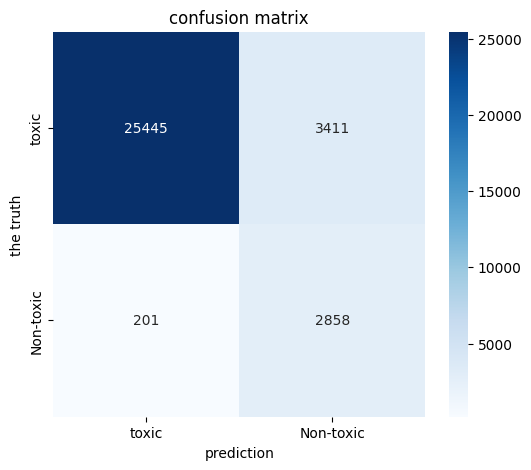

In [26]:
plt.figure(figsize=(6,5))
cm=confusion_matrix(y_test,y_pred)
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues',
           xticklabels=['toxic','Non-toxic'],
           yticklabels=['toxic','Non-toxic'])
plt.title('confusion matrix')
plt.xlabel('prediction')          
plt.ylabel('the truth')
plt.show()
          
          

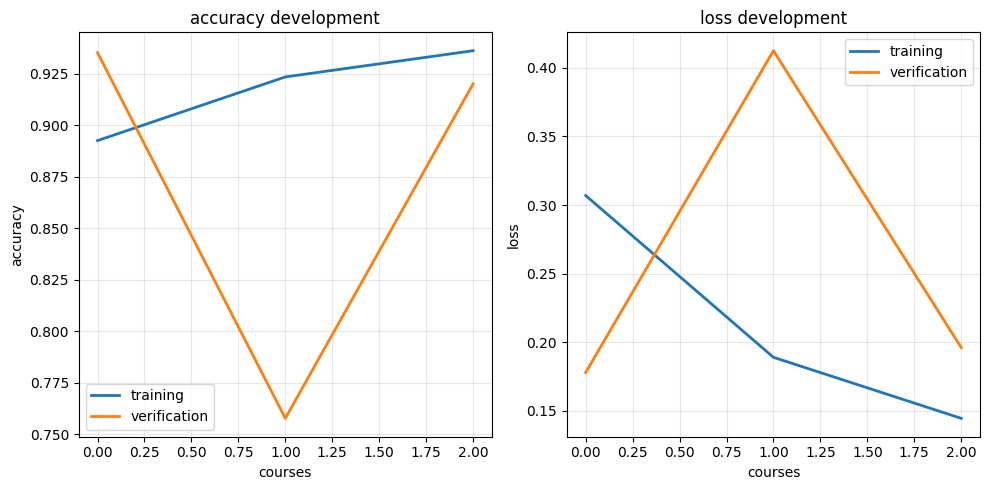

In [27]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'],label='training',linewidth=2)
plt.plot(history.history['val_accuracy'],label='verification',linewidth=2)
plt.title('accuracy development')
plt.xlabel('courses')
plt.ylabel('accuracy')
plt.legend()
plt.grid(True,alpha=0.3)

plt.subplot(1,2,2)
plt.plot(history.history['loss'],label='training',linewidth=2)
plt.plot(history.history['val_loss'],label='verification',linewidth=2)
plt.title('loss development')
plt.xlabel('courses')
plt.ylabel('loss')
plt.legend()
plt.grid(True,alpha=0.3)
plt.tight_layout()
plt.show()

In [28]:
def predict_toxicity(text):
    cleaned=clean_text(text)
    sequence=tokenizer.texts_to_sequences([cleaned])
    padded=pad_sequences(sequence,maxlen=max_length)
    prediction=model.predict(padded,verbose=0)[0][0]
    if prediction >0.7:
        status='very toxic'
        emoji= 'non-toxic'
    elif prediction >0.5:
        status='toxic'
        emoji= 'non-toxic' 
    elif prediction >0.3:
        status='neutral'
        emoji= 'non-toxic'
    else:
        status='non-toxic '
        emoji= 'non-toxic'  
    return prediction,status,emoji

In [29]:
test_comments=[
    'you are so stupid and idiot!',
    'this is a wonderful article,thanks for sharing',
    'i hate you, please die!',
    'great point,i completely agree with you',
    'you are a terrible person and everyone hates you',
    'thanks for the helpful information'
]
for i,comment in enumerate(test_comments,1):
    prob,status,emoji=predict_toxicity(comment)
    print(f'{emoji} {status}({prob:.3f})')
    print(f'{comment}')
model.save('toxic_comment_model.h5')

non-toxic very toxic(0.999)
you are so stupid and idiot!
non-toxic non-toxic (0.101)
this is a wonderful article,thanks for sharing
non-toxic very toxic(0.916)
i hate you, please die!
non-toxic non-toxic (0.189)
great point,i completely agree with you


non-toxic very toxic(0.895)
you are a terrible person and everyone hates you
non-toxic non-toxic (0.033)
thanks for the helpful information
